<div align="center">

<img src="../logo_isel.png" alt="ISEL" width="400"/>

<br><br>

**Instituto Superior de Engenharia de Lisboa**  
Licenciatura em Engenharia Informática e Multimédia  

<br><br>

### <u>Processamento de Imagem e Visão (PIV)</u>  
**Semestre de Inverno 25/26**

<br>

## 1º Trabalho Prático
**Contagem e Classificação de Peças LEGO**

<br><br><br>

<div align="left">

**Trabalho realizado por:**  
Miguel Cordeiro — nº 40765 — LEIM51N Grupo x  
Bruno Santos — nº 45096 — LEIM51N Grupo x  

**Docente:** Eng.º x 

</div>

</div>


### 1. Introdução

<div style="text-align: justify">
Neste trabalho, pretende-se desenvolver um algoritmo que seja capaz de contar um conjunto de ***peças de lego retangulares*** que foram colocadas em cima de uma mesa. Esta contagem não pode ser feita através da cor e o algoritmo é desenvolvido através da biblioteca de funções *OpenCV*, uma biblioteca usada na programação de aplicações de visão em tempo real para a linguagem de programação ***Python***.

Este algoritmo conta as peças com base nas suas dimensões. As dimensões a serem consideradas são ***2x2***, ***2x4***, ***2x6*** e ***2x8***. Qualquer outra peça que não se enquadre nestes formatos ou cujo o formato não seja perceptivel mesmo após o processamento das imagens e aplicação do algoritmo será considerada como ***Indefinido***.

Além da contagem de peças, o algoritmo irá tratar devidamente algumas perturbações que possam alterar as contagens, nomeadamente sombras, outras peças de lego no campo de visão e o contacto entre peças de lego.

**Conceitos Teóricos**

> Limiar Local: O limiar local é o valor de corte calculado para cada zona da imagem, em vez de um único valor global.

> Histograma de Imagens: É uma representação gráfica que mostra a distribuição de intensidades dos pixeis de uma imagem. Esta representação gráfica é fundamental na análise de uma imagem pois permite visualizar o número de pixeis por nível de brilho, do mais escuro para o mais claro.

> Binarização: A Binarização é um processo no qual se transforma uma imagem colorida ou em tons de cinza numa imagem binária, isto é, uma imagem representada apenas por duas cores: Preto e Branco.
> Este processo envolve a aplicação de um threshold, que determina os pixeis da imagem original serão convertidos para pretos e os que são convertidos para branco.
> Um caso particular sobre os tipos de métodos de Binarização é a Binarização Adaptativa, que foi o método adotado neste trabalho. Este método é especialmente útil em imagens com iluminação não uniforme porque permite preservar os detalhes em áreas com os mais variados contrastes.
> Uma das vantagens da Binarização é a redução da complexidade dos dados. Ao converter uma imagem em formato binário, os algoritmos de análise e processamento podem operar de forma mais eficiente, isto enquanto poupa tempo e recursos computacionais.

> ...

> Taxa Experimental de Erro (tee): é uma métrica utilizada na análise de dados e em diversas áreas da tecnologia da informação. Representa a proporção de erros relativamente ao total de tentativas ou de operações realizadas. Este é calculado dividindo o número de classificações erradas pelo número de testes realizados.

> Taxa Experimental de Rejeições (ter): é uma métrica utilizada na análise de dados e em diversas áreas da tecnologia da informação. Representa a proporção de rejeições relativamente ao total de tentativas ou de operações realizadas. Este é calculado dividindo o número de classificações rejeitadas pelo número de testes realizados.

</div>

    - Bibliotecas Importadas

In [51]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output, HBox, VBox

### 2. Leitura de Imagens

(530, 706, 3)
(530, 706)


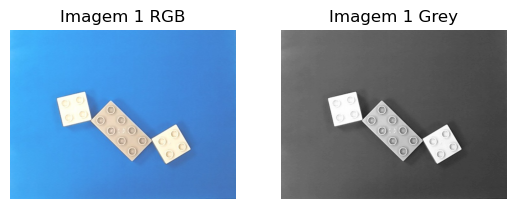

In [52]:
# Variavel de path [MUDAR PATH PARA TESTAR COM OUTRA IMAGEM]
path_img1 = "../images/lego04.jpg"
path_img2 = "../images/lego10.jpg"
path_img3 = "../images/lego11.jpg"
path_img4 = "../images/lego13.jpg"
path_img5 = "../images/lego32.jpg"
path_img6 = "../images/lego01.jpg"
path_img7 = "../images/lego02.jpg"
path_img8 = "../images/lego09.jpg"
path_img9 = "../images/lego12.jpg"
path_img10 = "../images/lego21.jpg"
path_img11 = "../images/lego22.jpg"
path_img12 = "../images/lego23.jpg"
path_img13 = "../images/lego25.jpg"
path_img14 = "../images/lego30.jpg"


# Ler imagens
img1 = cv2.imread(path_img1)
img2 = cv2.imread(path_img2)
img3 = cv2.imread(path_img3)
img4 = cv2.imread(path_img4)
img5 = cv2.imread(path_img5)
img6 = cv2.imread(path_img6)
img7 = cv2.imread(path_img7)
img8 = cv2.imread(path_img8)
img9 = cv2.imread(path_img9)
img10= cv2.imread(path_img10)
img11= cv2.imread(path_img11)
img12= cv2.imread(path_img12)
img13= cv2.imread(path_img13)
img14= cv2.imread(path_img14)

# Converter para RGB
img_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img_rgb3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img_rgb4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img_rgb5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img_rgb6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img_rgb7 = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)
img_rgb8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)
img_rgb9 = cv2.cvtColor(img9, cv2.COLOR_BGR2RGB)
img_rgb10 = cv2.cvtColor(img10, cv2.COLOR_BGR2RGB)
img_rgb11 = cv2.cvtColor(img11, cv2.COLOR_BGR2RGB)
img_rgb12 = cv2.cvtColor(img12, cv2.COLOR_BGR2RGB)
img_rgb13 = cv2.cvtColor(img13, cv2.COLOR_BGR2RGB)
img_rgb14 = cv2.cvtColor(img14, cv2.COLOR_BGR2RGB)

# Passar Imagem para Tons de Cinzento
img_gray1 = cv2.imread(path_img1, cv2.IMREAD_GRAYSCALE)
img_gray2 = cv2.imread(path_img2, cv2.IMREAD_GRAYSCALE)
img_gray3 = cv2.imread(path_img3, cv2.IMREAD_GRAYSCALE)
img_gray4 = cv2.imread(path_img4, cv2.IMREAD_GRAYSCALE)
img_gray5 = cv2.imread(path_img5, cv2.IMREAD_GRAYSCALE)
img_gray6 = cv2.imread(path_img6, cv2.IMREAD_GRAYSCALE)
img_gray7 = cv2.imread(path_img7, cv2.IMREAD_GRAYSCALE)
img_gray8 = cv2.imread(path_img8, cv2.IMREAD_GRAYSCALE)
img_gray9 = cv2.imread(path_img9, cv2.IMREAD_GRAYSCALE)
img_gray10 = cv2.imread(path_img10, cv2.IMREAD_GRAYSCALE)
img_gray11 = cv2.imread(path_img11, cv2.IMREAD_GRAYSCALE)
img_gray12 = cv2.imread(path_img12, cv2.IMREAD_GRAYSCALE)
img_gray13 = cv2.imread(path_img13, cv2.IMREAD_GRAYSCALE)
img_gray14 = cv2.imread(path_img14, cv2.IMREAD_GRAYSCALE)

# Canais de cores = 3
print(np.shape(img1))
print(np.shape(img_gray1))

# Mostrar imagem RGB
plt.subplot(1,2,1)
plt.imshow(img_rgb1)
plt.title("Imagem 1 RGB")
plt.axis("off")



# Mostrar imagem Grey
plt.subplot(1,2,2)
plt.imshow(img_gray1, cmap="gray")
plt.title("Imagem 1 Grey")
plt.axis("off")
plt.show()

Antes de passarmos para a binarização decidimos separar a imagem nos 3 canais de cor (R, G, B).

Ao analisar o histograma, concluímos que o canal vermelho apresenta a melhor separação de intensidades entre o fundo e as peças, o que facilita a aplicação de um threshold para isolar as peças da mesa.

Nesta etapa do projeto, chegamos então à conclusão, a partir do histograma com os canais de cor que o valor de Thrashold que iremos usar seria 110.

Em termos, neste canal de cor (Vermelho), o fundo representaria a aproximação da ausencia de cor (valor 0) e as peças a aproximação da cor vermelha (valor 255).

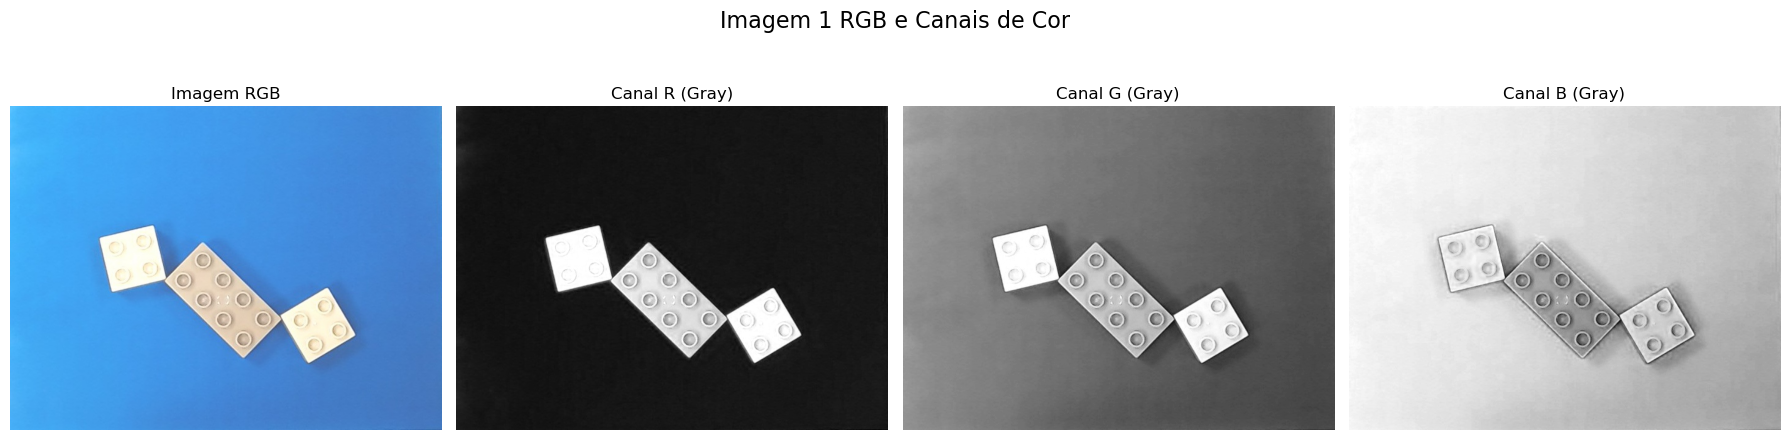

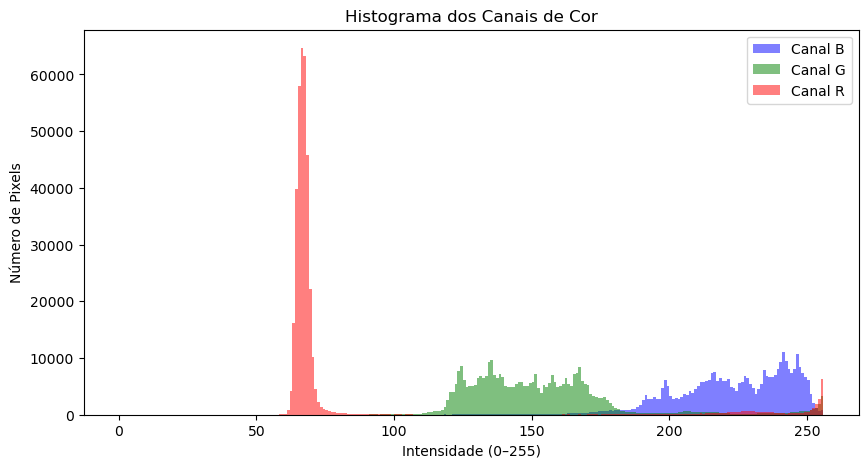

In [53]:
# Separa canais já em RGB (ordem: R, G, B)
r1, g1, b1 = cv2.split(img_rgb1)
zeros1 = np.zeros_like(r1)

# Constrói imagens dos canais em RGB
#img_red1 = np.dstack([r1, zeros1, zeros1])
#img_green1 = np.dstack([zeros1, g1, zeros1])
#img_blue1  = np.dstack([zeros1, zeros1, b1])

# Converter cada uma para tons de cinzento
#gray_red1 = cv2.cvtColor(img_red1, cv2.COLOR_RGB2GRAY)
#gray_green1 = cv2.cvtColor(img_green1, cv2.COLOR_RGB2GRAY)
#gray_blue1  = cv2.cvtColor(img_blue1, cv2.COLOR_RGB2GRAY)

# cria uma cópia independente dos valores do canal, preservando as intensidades originais (0–255) sem alterar ou reescalar a imagem
gray_red1 = r1.copy()
gray_green1 = g1.copy()
gray_blue1 = b1.copy()

# ___________________Canais de Cor PLOT___________________

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle("Imagem 1 RGB e Canais de Cor", fontsize=16)

# Imagem original
axes[0].imshow(img_rgb1)
axes[0].set_title("Imagem RGB")
axes[0].axis("off")

# Canal R
axes[1].imshow(gray_red1, cmap='gray')
axes[1].set_title("Canal R (Gray)")
axes[1].axis("off")

# Canal G
axes[2].imshow(gray_green1, cmap='gray')
axes[2].set_title("Canal G (Gray)")
axes[2].axis("off")

# Canal B
axes[3].imshow(gray_blue1, cmap='gray')
axes[3].set_title("Canal B (Gray)")
axes[3].axis("off")

plt.tight_layout()
plt.show()

# ___________________HISTOGRAMA PLOT___________________
plt.figure(figsize=(10,5))
plt.title("Histograma dos Canais de Cor")
plt.xlabel("Intensidade (0–255)")
plt.ylabel("Número de Pixels")

plt.hist(b1.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.5, label='Canal B')
plt.hist(g1.ravel(), bins=256, range=[0, 256], color='green', alpha=0.5, label='Canal G')
plt.hist(r1.ravel(), bins=256, range=[0, 256], color='red', alpha=0.5, label='Canal R')

plt.legend()
plt.show()

Célula Adicional para contruir os canais de cor das restantes imagens

In [54]:
# Separa canais já em RGB (ordem: R, G, B)
r2, g2, b2 = cv2.split(img_rgb2)
r3, g3, b3 = cv2.split(img_rgb3)
r4, g4, b4 = cv2.split(img_rgb4)
r5, g5, b5 = cv2.split(img_rgb5)
r6, g6, b6 = cv2.split(img_rgb6)
r7, g7, b7 = cv2.split(img_rgb7)
r8, g8, b8 = cv2.split(img_rgb8)
r9, g9, b9 = cv2.split(img_rgb9)
r10, g10, b10 = cv2.split(img_rgb10)
r11, g11, b11 = cv2.split(img_rgb11)
r12, g12, b12 = cv2.split(img_rgb12)
r13, g13, b13 = cv2.split(img_rgb13)
r14, g14, b14 = cv2.split(img_rgb14)

zeros2 = np.zeros_like(r2)
zeros3 = np.zeros_like(r3)
zeros4 = np.zeros_like(r4)
zeros5 = np.zeros_like(r5)
zeros6 = np.zeros_like(r6)
zeros7 = np.zeros_like(r7)
zeros8 = np.zeros_like(r8)
zeros9 = np.zeros_like(r9)
zeros10 = np.zeros_like(r10)
zeros11 = np.zeros_like(r11)
zeros12 = np.zeros_like(r12)
zeros13 = np.zeros_like(r13)
zeros14 = np.zeros_like(r14)

# Constrói imagens dos canais em RGB
# img_red2   = np.dstack([r2, zeros2, zeros2])
# img_green2 = np.dstack([zeros2, g2, zeros2])
# img_blue2  = np.dstack([zeros2, zeros2, b2])
# img_red3   = np.dstack([r3, zeros3, zeros3])
# img_green3 = np.dstack([zeros3, g3, zeros3])
# img_blue3  = np.dstack([zeros3, zeros3, b3])
# img_red4   = np.dstack([r4, zeros4, zeros4])
# img_green4 = np.dstack([zeros4, g4, zeros4])
# img_blue4  = np.dstack([zeros4, zeros4, b4])
# img_red5   = np.dstack([r5, zeros5, zeros5])
# img_green5 = np.dstack([zeros5, g5, zeros5])
# img_blue5  = np.dstack([zeros5, zeros5, b5])
# ...

# Converter cada uma para tons de cinzento
# gray_red2   = cv2.cvtColor(img_red2, cv2.COLOR_RGB2GRAY)
# gray_green2 = cv2.cvtColor(img_green2, cv2.COLOR_RGB2GRAY)
# gray_blue2  = cv2.cvtColor(img_blue2, cv2.COLOR_RGB2GRAY)
# gray_red3   = cv2.cvtColor(img_red3, cv2.COLOR_RGB2GRAY)
# gray_green3 = cv2.cvtColor(img_green3, cv2.COLOR_RGB2GRAY)
# gray_blue3  = cv2.cvtColor(img_blue3, cv2.COLOR_RGB2GRAY)
# gray_red4   = cv2.cvtColor(img_red4, cv2.COLOR_RGB2GRAY)
# gray_green4 = cv2.cvtColor(img_green4, cv2.COLOR_RGB2GRAY)
# gray_blue4  = cv2.cvtColor(img_blue4, cv2.COLOR_RGB2GRAY)
# gray_red5   = cv2.cvtColor(img_red5, cv2.COLOR_RGB2GRAY)
# gray_green5 = cv2.cvtColor(img_green5, cv2.COLOR_RGB2GRAY)
# gray_blue5  = cv2.cvtColor(img_blue5, cv2.COLOR_RGB2GRAY)
# ...

gray_red2 = r2.copy()
gray_green2 = g2.copy()
gray_blue2 = b2.copy()
gray_red3 = r3.copy()
gray_green3 = r3.copy()
gray_blue3 = b3.copy()
gray_red4 = r4.copy()
gray_green4 = g4.copy()
gray_blue4 = b4.copy()
gray_red5 = r5.copy()
gray_green5 = g5.copy()
gray_blue5 = b5.copy()

gray_red6 = r6.copy()
gray_green6 = g6.copy()
gray_blue6 = b6.copy()
gray_red7 = r7.copy()
gray_green7 = g7.copy()
gray_blue7 = b7.copy()
gray_red8 = r8.copy()
gray_green8 = g8.copy()
gray_blue8 = b8.copy()
gray_red9 = r9.copy()
gray_green9 = g9.copy()
gray_blue9 = b9.copy()
gray_red10 = r10.copy()
gray_green10 = g10.copy()
gray_blue10 = b10.copy()
gray_red11 = r11.copy()
gray_green11 = g11.copy()
gray_blue11 = b11.copy()
gray_red12 = r12.copy()
gray_green12 = g12.copy()
gray_blue12 = b12.copy()
gray_red13 = r13.copy()
gray_green13 = g13.copy()
gray_blue13 = b13.copy()
gray_red14 = r14.copy()
gray_green14 = g14.copy()
gray_blue14 = b14.copy()

### 3. Binarização

Começamos o processo de binarização antes de descobrir a melhor forma de analisar a imagem e a separação de canais de cor (R, G, B) antes de passar para este processo. Deste modo, dividimos esta secção em duas tentativas, sendo a segunda a correta, com o melhor resultado de Binarização.

    - Primeira Tentativa

Usamos um filtro Gaussian Blur para reduzir o ruido. Um filtro Gaussiano é um filtro passa-baixa que remove os componentes de alta frequência. o Gaussian Blur calcula a média ponderada dos pixeis vizinhos a cada ponto da imagem. Quanto maior o raio do filtro, mais suave será o efeito aplicado. Isto sucede porque este filtro realça melhor quanto mais próximo os pixeis estiverem do ponto central, o que resulta numa transição suave entre cores.

In [55]:
# Suavizar ligeiramente para reduzir ruído
img_blur_1t = cv2.GaussianBlur(gray_red1, (5, 5), 0)

Para binarização precisavamos usar um Threshold para converter a imagem (cinzento com o filtro Gaussian aplicado) em uma imagem binária. 

Em vez de um Threshold Simples (dado em aula), optamos por usar um threshold adaptativo porque embora todas as imagens terem um background de uma so cor definida este adapta-se melhor a variações de luz local e lida bem com sombras.

Parametros:
- blockSize: Tamanho da vizinhança.
    - Testamos vários valores para o tamanho da vizinhança para conseguirmos obter o melhor resultado de binarização, embora sempre valores impares (com objetivo de existir sempre um centro para o pixel a ser analisado).
- C: Ajusta a agressividade do filtro.



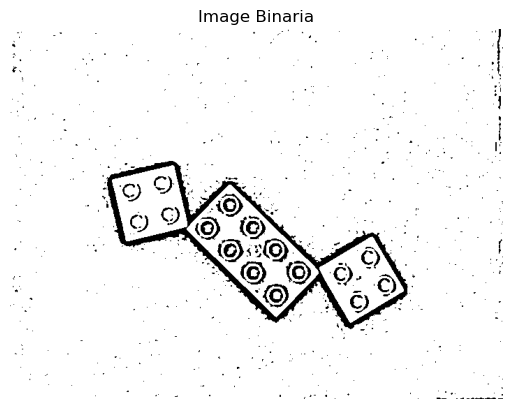

In [56]:
# Threshold adaptativo
blockSize = 15 # blockSize: tamanho da vizinhança (impar)
C = 2 # agressividade do filtro
adaptativeThreshold = cv2.adaptiveThreshold(img_blur_1t, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C)

# Mostrar imagem
plt.imshow(adaptativeThreshold, cmap="gray")
plt.title("Image Binaria")
plt.axis("off")  # Remove os eixos
plt.show()

Como já brevemente referido no Markdown em cima, esta tentativa foi realizada com o canal de cor simples em Gray apenas. Complicamos o processo para chegar ao resultado mais esperado e depois chegamos à conclusão que, a partir da separação em canais de cor (R, G, B) conseguiriamos obter o melhor resultado mesmo antes de efetuarmos filtros e binarização.

    - Segunda Tentativa

Nesta segunda tentativa, a correta, começamos por aplicar um filtro do tipo GaussianBlur com o objetivo de suavizar o ruído presente na imagem.

Este filtro realiza uma média ponderada das intensidades dos pixels vizinhos, reduzindo variações abruptas causadas por iluminação ou pequenas imperfeições no fundo, o que facilita a etapa de binarização.

De seguida, aplicamos um Threshold (Binarização) com o valor a 85, retirado no histograma dos canais de cor e conseguimos obter um resultado muito perto do resultado esperado. Este valor permite então criar um barreira entre o que são valores 1 (Cor) e o que são valores 0 (Ausencia de Cor), separando assim por completo as peças do fundo.

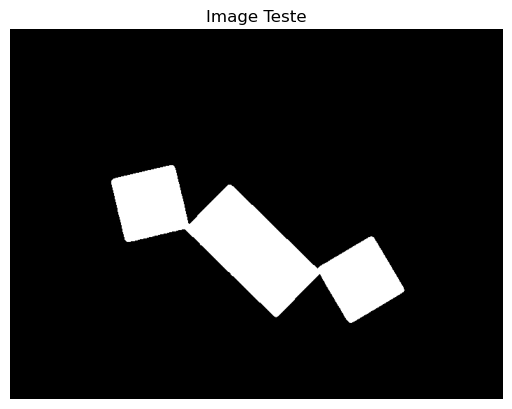

In [57]:
# Suavizar ruído
gr_blur1 = cv2.GaussianBlur(gray_red1, (5, 5), 0)
T1, bw1 = cv2.threshold(gr_blur1, 110, 255, cv2.THRESH_BINARY)

plt.imshow(bw1, cmap="gray")
plt.title("Image Teste")
plt.axis("off")  # Remove os eixos
plt.show()


Realizamos todos os plots dos casos possiveis para podermos alinhar quais os proximos passos para melhoramento da imagem.

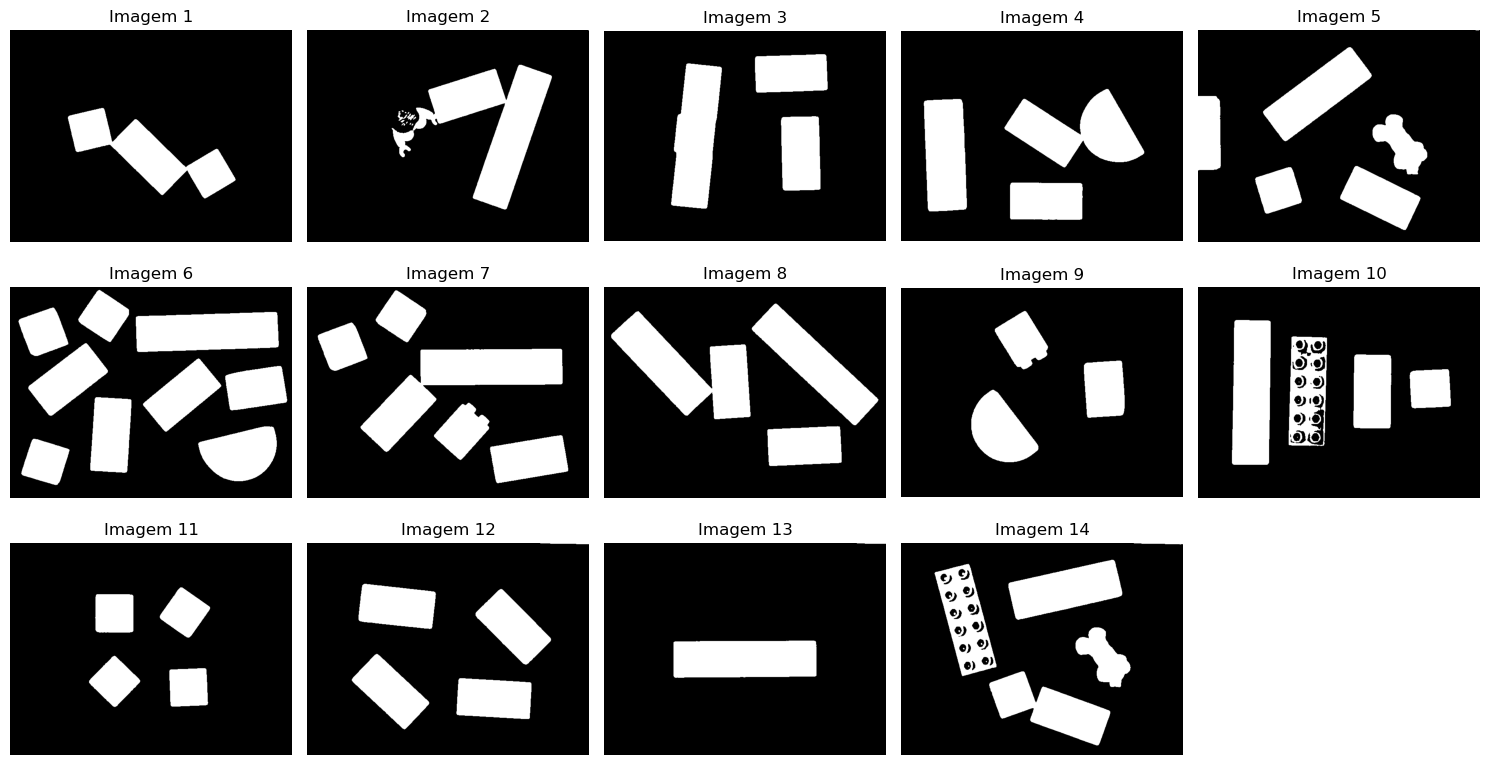

In [58]:
gr_blur2 = cv2.GaussianBlur(gray_red2, (5, 5), 0)
gr_blur3 = cv2.GaussianBlur(gray_red3, (5, 5), 0)
gr_blur4 = cv2.GaussianBlur(gray_red4, (5, 5), 0)
gr_blur5 = cv2.GaussianBlur(gray_red5, (5, 5), 0)
gr_blur6 = cv2.GaussianBlur(gray_red6, (5, 5), 0)
gr_blur7 = cv2.GaussianBlur(gray_red7, (5, 5), 0)
gr_blur8 = cv2.GaussianBlur(gray_red8, (5, 5), 0)
gr_blur9 = cv2.GaussianBlur(gray_red9, (5, 5), 0)
gr_blur10 = cv2.GaussianBlur(gray_red10, (5, 5), 0)
gr_blur11 = cv2.GaussianBlur(gray_red11, (5, 5), 0)
gr_blur12 = cv2.GaussianBlur(gray_red12, (5, 5), 0)
gr_blur13 = cv2.GaussianBlur(gray_red13, (5, 5), 0)
gr_blur14 = cv2.GaussianBlur(gray_red14, (5, 5), 0)


T2, bw2 = cv2.threshold(gr_blur2, 110, 255, cv2.THRESH_BINARY)
T3, bw3 = cv2.threshold(gr_blur3, 110, 255, cv2.THRESH_BINARY)
T4, bw4 = cv2.threshold(gr_blur4, 110, 255, cv2.THRESH_BINARY)
T5, bw5 = cv2.threshold(gr_blur5, 110, 255, cv2.THRESH_BINARY)
T6, bw6 = cv2.threshold(gr_blur6, 110, 255, cv2.THRESH_BINARY)
T7, bw7 = cv2.threshold(gr_blur7, 110, 255, cv2.THRESH_BINARY)
T8, bw8 = cv2.threshold(gr_blur8, 110, 255, cv2.THRESH_BINARY)
T9, bw9 = cv2.threshold(gr_blur9, 110, 255, cv2.THRESH_BINARY)
T10, bw10 = cv2.threshold(gr_blur10, 110, 255, cv2.THRESH_BINARY)
T11, bw11 = cv2.threshold(gr_blur11, 110, 255, cv2.THRESH_BINARY)
T12, bw12 = cv2.threshold(gr_blur12, 110, 255, cv2.THRESH_BINARY)
T13, bw13 = cv2.threshold(gr_blur13, 110, 255, cv2.THRESH_BINARY)
T14, bw14 = cv2.threshold(gr_blur14, 110, 255, cv2.THRESH_BINARY)


# PLOTS

bws = [bw1, bw2, bw3, bw4, bw5, bw6, bw7, bw8, bw9, bw10, bw11, bw12, bw13, bw14]
titulos = [
    "Imagem 1", "Imagem 2", "Imagem 3", "Imagem 4", "Imagem 5",
    "Imagem 6", "Imagem 7", "Imagem 8", "Imagem 9", "Imagem 10",
    "Imagem 11", "Imagem 12", "Imagem 13", "Imagem 14"
]

plt.figure(figsize=(15, 8))  # tamanho ajustado para 3 linhas

# plotar todas as 14 imagens
for i in range(14):
    plt.subplot(3, 5, i + 1)  # 3 linhas, 5 colunas (a última ficará com 4)
    plt.imshow(bws[i], cmap="gray")
    plt.title(titulos[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

### 3. Melhoramento da Imagem

Com estes novos plots das binarizações em todos os casos, conseguimos tirar a conclusão de a existência de novos problemas. A existencia de buracos nas imagens 10 e 14 e algumas peças que tocam umas nas outras, dificultando assim o processo de separação de objetos.

Para retirar esse efeito vamos usar 4 funções:

    - Função Close - Fechar Buracos

    - Função Erode - Corroi Objetos

    - Função Dilate - Dilata Objetos

    - Função Open - Abrir Buracos

Comecei por definir o valor de Kernel para os métodos MorphologyEx (Open and Close) e o valor de Element para os métodos Erode e Dilate.

O valor de kernel define a “área de influência” da operação morfológica.
- quanto maior for o kernel, maior a área afetada pela operação;

- quanto menor, mais suave e localizado é o efeito

O valor de Element (elemento estruturante) funciona como o Kernel mas para as funções de Erode e Dilate. Diferimos o nome para termos valores de Kernel diferentes dos valores para o Close e Open.

In [59]:
kernel = np.ones((13,13), np.uint8)
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (75,75))

**Função MorphologyEx (CLOSE)**

Esta função preenche pequenas regiões pretas no interior das peças brancas, tornando as formas mais sólidas e contínuas.

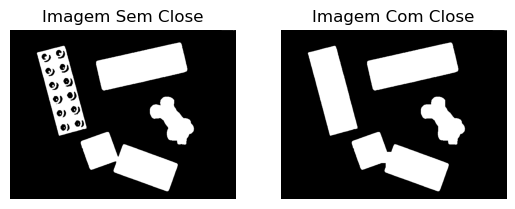

In [60]:
# Fechar Buracos
# Fui ajustando o valor de kernel para conseguir prencher os buracos da peça exemplo que estou a usar.
img_closed1 = cv2.morphologyEx(bw14, cv2.MORPH_CLOSE, kernel)
plt.subplot(1,2,1)
plt.imshow(bw14, cmap='gray')
plt.title("Imagem Sem Close")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_closed1, cmap='gray')
plt.title("Imagem Com Close")
plt.axis("off")
plt.show()

**Função Erode**

Reduz ligeiramente o tamanho das peças brancas, separando objetos que se encontram colados.

Ajustamos o valor da variavel Element para reduzirmos os objetos com objetivo de posteriormente voltarmos a aumentar ligeiramente, arredondado e separando-os uns dos outros.

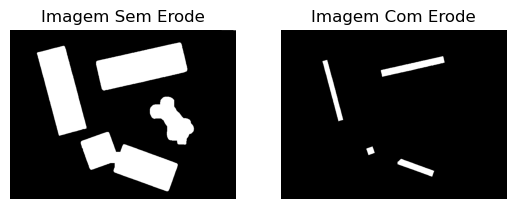

In [61]:
img_erode1 = cv2.erode(img_closed1, element, iterations=1)

plt.subplot(1,2,1)
plt.imshow(img_closed1, cmap='gray')
plt.title("Imagem Sem Erode")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_erode1, cmap='gray')
plt.title("Imagem Com Erode")
plt.axis("off")
plt.show()

**Função Dilate**

Faz crescer novamente as peças após a erosão, restaurando as suas dimensões originais sem voltar a uni-las.

Ajustamos o tamanho das peças para o original, com ambos os cantos arredondados, com objetivo de as separar.

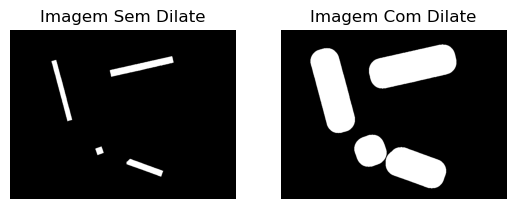

In [62]:
img_dilate1 = cv2.dilate(img_erode1, element, iterations=1)

plt.subplot(1,2,1)
plt.imshow(img_erode1, cmap='gray')
plt.title("Imagem Sem Dilate")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_dilate1, cmap='gray')
plt.title("Imagem Com Dilate")
plt.axis("off")
plt.show()

**Função MorphologyEx (OPEN)**

Remove os pequenos elementos brancos isolados e suaviza o contorno dos objetos, garantindo uma segmentação mais limpa.

Ajustei o valor de Kernel de forma a que não interfira com o objetivo do close e que use bem o open, como por exemplo, na imagem 3 em que temos um pouco de branco a sair do objeto e queremos ajustar.

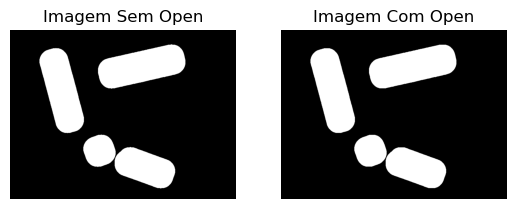

In [63]:
img_opened1 = cv2.morphologyEx(img_dilate1, cv2.MORPH_OPEN,  kernel,  iterations=1)

plt.subplot(1,2,1)
plt.imshow(img_dilate1, cmap='gray')
plt.title("Imagem Sem Open")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_opened1, cmap='gray')
plt.title("Imagem Com Open")
plt.axis("off")
plt.show()

Começamos por separar os valores de kernel para o Open e para o Close e os valores de Element para o Erode e o Dilate com o objetivo de tornar o sistema ainda mais preciso para todos os casos possiveis.

Para facilitar a procura do valor de Kernels e Elements, recorri ao OpenAI (ChatGPT – modelo GPT-5 Thinking) para me gerar um código com ipywidgets, garantindo tamanhos ímpares dos kernels e elements e aplicando as operações Close/Erode/Dilate/Open ao conjunto das 14 imagens binárias.

O código foi posteriormente revisto, testado e adaptado por mim. Adicionei possibilidade de alterar  as formas RECT/ELLIPSE/CROSS e removi uma funcionalidade não necessárias como "Link CLOSE/OPEN sizes".

PROMPT: Faça-me um painel interativo em Jupyter com ipywidgets para testar operações morfológicas do OpenCV nas 14 imagens binárias (bw1, bw2, ..., bw14). Pretendo conseguir de forma interativa mover os valores de Kernel Close, Kernel Open, Element Erode, Element Dilate e visualizar o resultado das funções de qualidade de imagem no plot.



In [64]:
# Helper function to display images inline
def show_image(img, title="Image", cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

def set_subimage(sub_plt,img, title="Image", cmap=None):
    sub_plt.imshow(img, cmap=cmap)
    sub_plt.set_title(title)
    sub_plt.axis("off")

# garante tamanho ímpar
def odd(n):
    n = int(n)
    return n if n % 2 == 1 else n + 1

shape_map = {"RECT": cv2.MORPH_RECT, "ELLIPSE": cv2.MORPH_ELLIPSE, "CROSS": cv2.MORPH_CROSS}

def imageUpgrade_separado(image, kernel_close, kernel_open, element_erode, element_dilate):
    img_closed  = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
    img_erode   = cv2.erode(img_closed,  element_erode,  iterations=1)
    img_dilate  = cv2.dilate(img_erode,  element_dilate, iterations=1)
    img_opened  = cv2.morphologyEx(img_dilate, cv2.MORPH_OPEN, kernel_open, iterations=1)
    return img_opened

# ----------------- widgets -----------------
# CLOSE
w_kclose_size  = widgets.IntSlider(value=3, min=1, max=101, step=2, description="CLOSE size")
w_kclose_shape = widgets.Dropdown(options=["RECT","ELLIPSE","CROSS"], value="RECT", description="CLOSE shape")

# OPEN
w_kopen_size   = widgets.IntSlider(value=3, min=1, max=101, step=2, description="OPEN size")
w_kopen_shape  = widgets.Dropdown(options=["RECT","ELLIPSE","CROSS"], value="RECT", description="OPEN shape")

# ERODE
w_ero_size     = widgets.IntSlider(value=3, min=1, max=101, step=2, description="ERODE size")
w_ero_shape    = widgets.Dropdown(options=["RECT","ELLIPSE","CROSS"], value="RECT", description="ERODE shape")

# DILATE
w_dil_size     = widgets.IntSlider(value=3, min=1, max=101, step=2, description="DILATE size")
w_dil_shape    = widgets.Dropdown(options=["RECT","ELLIPSE","CROSS"], value="RECT", description="DILATE shape")

w_link_kernels = widgets.Checkbox(value=False, description="Link CLOSE/OPEN sizes")
w_link_elements= widgets.Checkbox(value=False, description="Link ERODE/DILATE sizes")

# ----------------- sincronização opcional -----------------
def _sync_kernel_size(change):
    if w_link_kernels.value and change["name"] == "value":
        if change["owner"] is w_kclose_size:
            w_kopen_size.value = change["new"]
        elif change["owner"] is w_kopen_size:
            w_kclose_size.value = change["new"]

def _sync_element_size(change):
    if w_link_elements.value and change["name"] == "value":
        if change["owner"] is w_ero_size:
            w_dil_size.value = change["new"]
        elif change["owner"] is w_dil_size:
            w_ero_size.value = change["new"]

for w in (w_kclose_size, w_kopen_size):
    w.observe(_sync_kernel_size, names="value")
for w in (w_ero_size, w_dil_size):
    w.observe(_sync_element_size, names="value")

# ----------------- função principal -----------------
def run(kclose_size, kclose_shape, kopen_size, kopen_shape,
        ero_size, ero_shape, dil_size, dil_shape,
        link_kernels, link_elements):

    # obtém as 14 imagens automaticamente
    images = [globals()[f"bw{i}"] for i in range(1, 15)]

    ks_close = odd(kclose_size)
    ks_open  = odd(kopen_size)
    es_ero   = odd(ero_size)
    es_dil   = odd(dil_size)

    kernel_close  = cv2.getStructuringElement(shape_map[kclose_shape], (ks_close, ks_close))
    kernel_open   = cv2.getStructuringElement(shape_map[kopen_shape],  (ks_open,  ks_open))
    element_ero   = cv2.getStructuringElement(shape_map[ero_shape],    (es_ero,  es_ero))
    element_dil   = cv2.getStructuringElement(shape_map[dil_shape],    (es_dil,  es_dil))

    # aplica a todos
    results = [imageUpgrade_separado(img, kernel_close, kernel_open, element_ero, element_dil) for img in images]

    # mostra em grade
    ncols = 4
    nrows = int(np.ceil(len(results)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
    axes = axes.ravel()

    for i, (ax, img) in enumerate(zip(axes, results)):
        ax.imshow(img, cmap='gray')
        ax.set_title(f"bw{i+1}")
        ax.axis('off')

    # remove eixos extras se houver
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(
        f"CLOSE=({ks_close},{kclose_shape}) | "
        f"ERODE=({es_ero},{ero_shape}) | "
        f"DILATE=({es_dil},{dil_shape}) | "
        f"OPEN=({ks_open},{kopen_shape})",
        fontsize=10
    )
    plt.tight_layout()
    plt.show()

# layout
ui = VBox([
    HBox([w_kclose_size, w_kclose_shape]),
    HBox([w_kopen_size,  w_kopen_shape]),
    w_link_kernels,
    HBox([w_ero_size,    w_ero_shape]),
    HBox([w_dil_size,    w_dil_shape]),
    w_link_elements
])

out = interactive_output(
    run,
    dict(
        kclose_size=w_kclose_size,
        kclose_shape=w_kclose_shape,
        kopen_size=w_kopen_size,
        kopen_shape=w_kopen_shape,
        ero_size=w_ero_size,
        ero_shape=w_ero_shape,
        dil_size=w_dil_size,
        dil_shape=w_dil_shape,
        link_kernels=w_link_kernels,
        link_elements=w_link_elements
    )
)

display(ui, out)


Output()

Depois de alguns testes, estes foram os melhores valores obtidos foram:
- Kernel Close = 19
- Kernel Open = 3
- Element Erode = 49
- Element Dilate = 9
<img src="../image_upgrade_result.png" alt="result_upgrade" width="900"/>

Criei uma função que junta as 4 funções de melhoramento de imagem que iremos usar.

In [65]:
def imageUpgrade(image, kernel_close, kernel_open, element_ero, element_dil):
    img_closed1 = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
    img_erode1 = cv2.erode(img_closed1, element_ero, iterations=1)
    img_dilate1 = cv2.dilate(img_erode1, element_dil, iterations=1)
    img_opened1 = cv2.morphologyEx(img_dilate1, cv2.MORPH_OPEN,  kernel_open,  iterations=1)
    return img_opened1

Plot das Imagens apenas com Binarização:

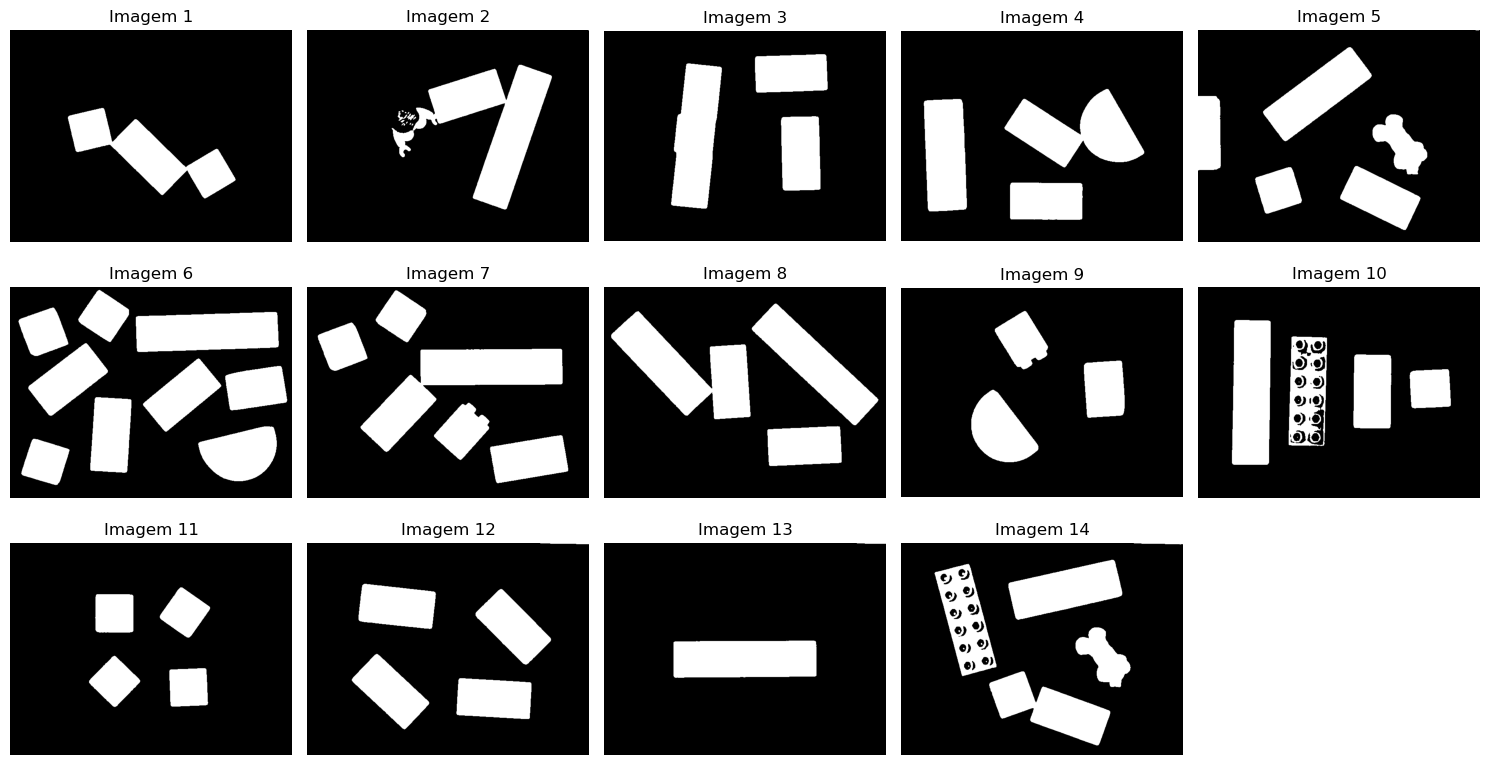

In [66]:
bws = [bw1, bw2, bw3, bw4, bw5, bw6, bw7, bw8, bw9, bw10, bw11, bw12, bw13, bw14]
titulos = [
    "Imagem 1", "Imagem 2", "Imagem 3", "Imagem 4", "Imagem 5",
    "Imagem 6", "Imagem 7", "Imagem 8", "Imagem 9", "Imagem 10",
    "Imagem 11", "Imagem 12", "Imagem 13", "Imagem 14"
]

plt.figure(figsize=(15, 8))  # tamanho ajustado para 3 linhas

# plotar todas as 14 imagens
for i in range(14):
    plt.subplot(3, 5, i + 1)  # 3 linhas, 5 colunas (a última ficará com 4)
    plt.imshow(bws[i], cmap="gray")
    plt.title(titulos[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

Aqui efetuamos a função de melhoramento de imagem para todas as imagens da nosa base de dados, com os melhores parametros encontrados para separação de peças e fundo.

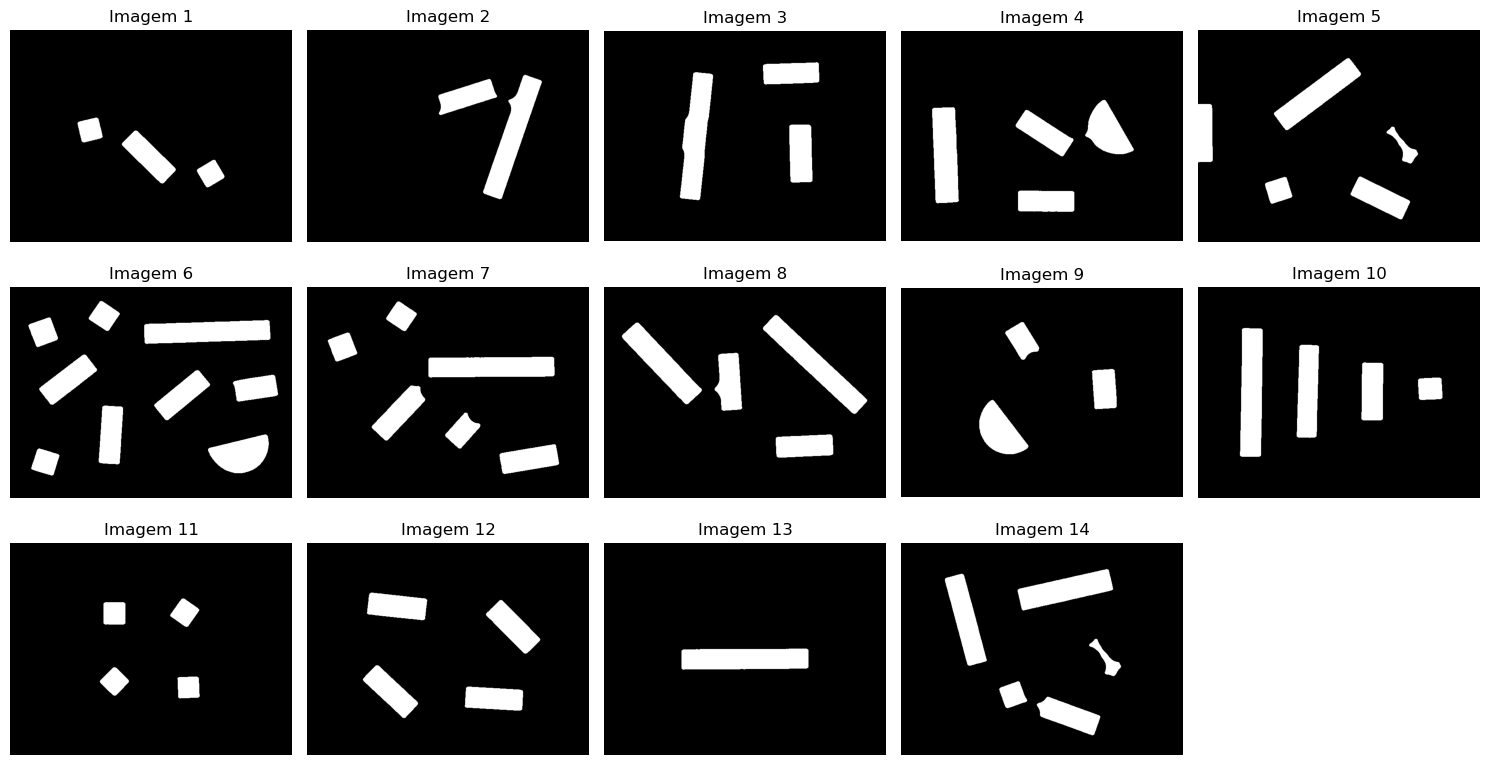

In [67]:
# Definir valores de kernel e element escolhidos em cima
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))
kernel_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
element_ero  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (49,49))
element_dil  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))

# Imagens Binárias
bws = [bw1, bw2, bw3, bw4, bw5, bw6, bw7, bw8, bw9, bw10, bw11, bw12, bw13, bw14]

updated_images = []

# Corre todas as imagens binárias e aplica a função com os parametros acima definidos
for i, img in enumerate(bws, start=1):
    result = imageUpgrade(img, kernel_close, kernel_open, element_ero, element_dil)
    updated_images.append(result)
    globals()[f"img_final{i}"] = result

titulos = [
    "Imagem 1", "Imagem 2", "Imagem 3", "Imagem 4", "Imagem 5",
    "Imagem 6", "Imagem 7", "Imagem 8", "Imagem 9", "Imagem 10",
    "Imagem 11", "Imagem 12", "Imagem 13", "Imagem 14"
]

plt.figure(figsize=(15, 8))  # tamanho ajustado para 3 linhas

# plotar todas as 14 imagens
for i in range(14):
    plt.subplot(3, 5, i + 1)  # 3 linhas, 5 colunas (a última ficará com 4)
    plt.imshow(updated_images[i], cmap="gray")
    plt.title(titulos[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


### 4. Sistemas de Classificação

Começamos por definir um sistema de classificação, para isso, necessitamos de definir:
- Classes de Interesse
- Definir Sensores
- Extração de Caracteristicas (features)

E por fim definimos o classificador com base nestes 3 pontos.

**Classes de Interesse**

[2x2, 2x4, 2x6, 2x8]

Tudo o que não se classificar nestes 4 objetos será considerado classe de rejeição.

**Definir Sensores**

Usamos como sensores uma camera

**Extração de Caracteristicas (features)**

A partir da definição de sensores podemos comparar as caracteristicas em comum que retiramos dos objetos que pretendemos classificar, desde modo, irmos usar caracteristicas como a area.

### x. Avaliação do Sistema

Para avaliação do sistema recorremos a uma matriz de confusão, numa das imagens teste, a partir do calculo da Taxa Experimental de Erro (tee) e da Taxa Experimental de Rejeições (ter).

Deste modo iremos obter a avaliação do funcionamento do sistema de classificação que implementamos.

FONTES:

https://kfcdicasdigital.com/glossario/o-que-e-binarizacao-de-imagem/

https://clubedogis.com.br/glossario/o-que-e-histogramas-de-imagens-guia-completo/

https://tutoriais.edu.lat/pub/opencv/opencv-gaussian-blur/opencv-gaussian-blur

https://soescola.com/glossario/o-que-e-gaussian-blur#google_vignette